# Generating molecules with a ChEMBL_23 trained autoencoder

In [1]:
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from model import MoleculeVAE
from utils import encode_smiles, decode_latent_molecule, interpolate, get_unique_mols

# number of dimensions to represent the molecules
# as the model was trained with this number, any operation made with the model must share the dimensions.
latent_dim = 292

# trained_model 0.9769 validation accuracy
# trained with 80% of ALL chembl molecules, validated on the other 20.
trained_model = 'chembl_23_model.h5'
charset_file = 'charset.json'

aspirin_smiles = 'CC(=O)Oc1ccccc1C(=O)O'

Using TensorFlow backend.


# Load the model

In [2]:
# load charset and model
with open('charset.json', 'r') as outfile:
    charset = json.load(outfile)

model = MoleculeVAE()
model.load(charset, trained_model, latent_rep_size = latent_dim)

# Encode aspirin SMILES into it's latent representation
- Our aspirin now looks like a 292 dimension continuous array...

In [3]:
aspirin_latent = encode_smiles(aspirin_smiles, model, charset)
aspirin_latent

array([[  3.27550881e-02,  -1.15584075e-01,   1.69903338e-02,
          1.08153082e-01,   1.88147910e-02,   4.46237512e-02,
         -2.74537448e-02,  -3.17353234e-02,   2.90942546e-02,
          3.20587829e-02,   3.66459936e-02,   9.56652313e-02,
         -2.47274637e-02,  -1.98485833e-02,   2.04687146e-03,
          4.69892770e-02,  -9.14182141e-03,  -5.60991988e-02,
          9.71591920e-02,   6.94430098e-02,  -1.52211459e-02,
         -1.16096191e-01,   7.26182293e-03,   7.55512342e-02,
          4.72349823e-02,  -2.31203046e-02,   1.08116537e-01,
         -7.64499828e-02,  -1.62300944e-01,  -1.13442540e-03,
         -2.54060701e-02,   4.72149178e-02,   1.46798939e-02,
         -6.26141578e-02,  -7.25823417e-02,  -3.85267939e-03,
          9.28472728e-05,   9.98463780e-02,   3.18826102e-02,
          4.04943228e-02,  -3.66333239e-02,   1.26148567e-01,
         -2.33238339e-02,  -3.34577076e-02,  -1.66121125e-02,
         -6.73705563e-02,  -3.46895903e-02,  -3.07432376e-03,
        

# Silly check: Are we reconstructing our aspirin properly?
- Looks like we are able to convert aspirin SMILES to a 292 dimension array and go back from it, good!

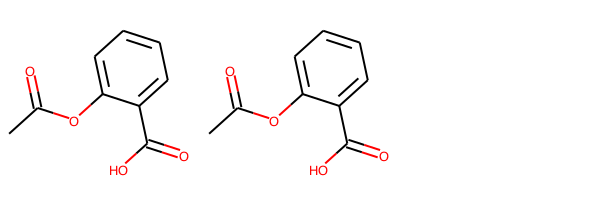

In [4]:
reconstructed_aspirin = decode_latent_molecule(aspirin_latent, model, charset, latent_dim)
original = Chem.MolFromSmiles(aspirin_smiles)
reconstructued = Chem.MolFromSmiles(reconstructed_aspirin)

Draw.MolsToGridImage([original, reconstructued])

# Looking for 1k aspirin neighbours 
- Generating 1k random 292 dimension continuous arrays with mean=aspirin_latent and stdev==0.1 to sample the latent space next to the aspirin. 

In [5]:
stdev = 0.1
latent_mols = stdev * np.random.randn(1000, latent_dim) + aspirin_latent

# Decode the randomly aspirin centered generated latent representations
- We just generated some arrays, we now want molecules!

In [6]:
decoded_molecules = []
for lm in latent_mols:
    decoded_molecules.append(decode_latent_molecule(lm, model, charset, latent_dim))

# Validate the molecules using RDKit
- RDKit is always handful tool to check molecule validity.
- Most of the 1k latent representations won't end in a valid molecule, this is completelly normal due to the complexity of the chemical space. Also notice that this is NOT a perfect autoencoder, it's trained with a validation accuracy of 0.9769, so some molecules won't be correctly decoded after the encoding phase.

In [7]:
from rdkit import Chem
from rdkit import RDLogger

# remove warnings and errors from notebook (lots of them due non valid molecule generation)
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

working_mols = []
for smiles in decoded_molecules:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_mols.append(mol)
    except:
        continue

# Let's visualise the aspirinish molecules we artificially generated!

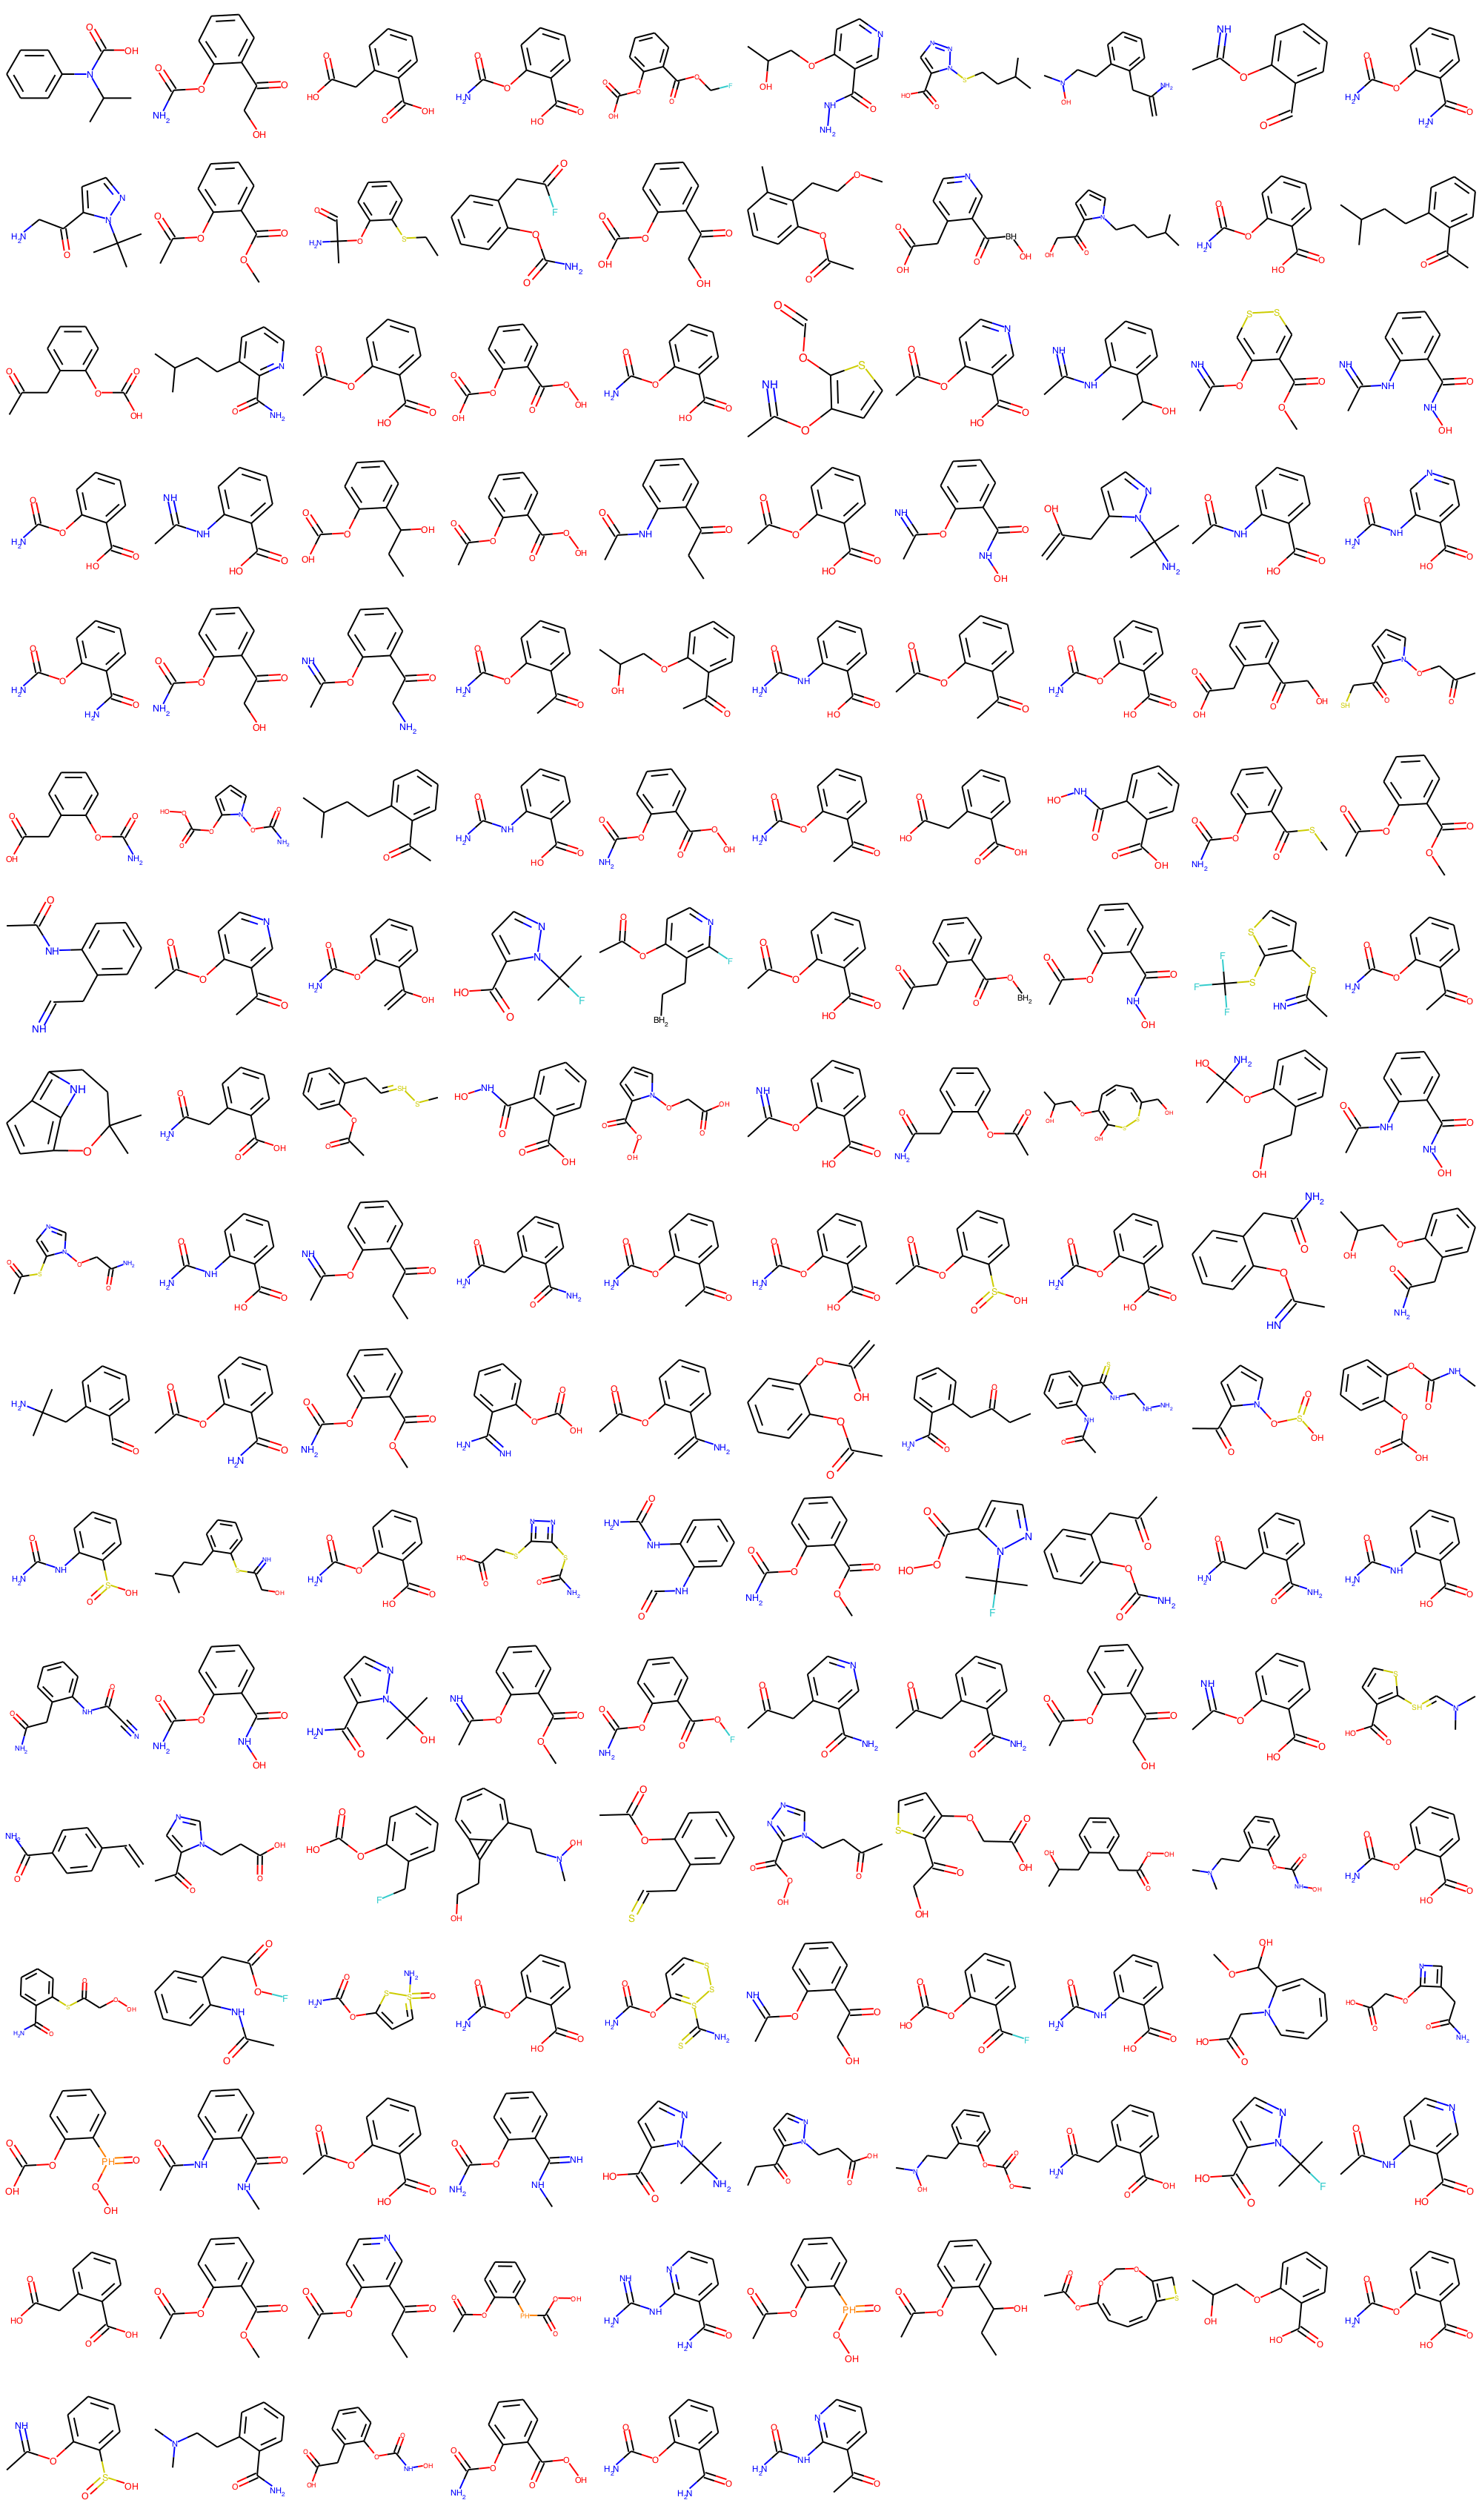

In [8]:
Draw.MolsToGridImage([mol for mol in working_mols], molsPerRow=10)

# Check how many of them we can find using UniChem 
- We managed to generate many unique valid molecules, most of them not existing in ChEMBL. 
- This means that we can sample the model which is representing the ChEMBL chemical space to retrieve molecules that don't exist in the database.

In [9]:
import requests

url = 'https://www.ebi.ac.uk/unichem/rest/inchikey/{}'

unique_mols = get_unique_mols(working_mols)

in_unichem = []
for um in unique_mols:
    res = requests.get(url.format(um[1]))
    if res.status_code == 200:
        in_unichem.append([um[0], res.json()])

not_in_chembl = filter(lambda mol: 1 not in [int(res['src_id']) for res in mol[1]], in_unichem)

print "rdkit valid mols:", len(working_mols)
print "unique molecules:", len(unique_mols)
print "found in unichem:", len(in_unichem)
print "found in unichem and not in chembl:", len(not_in_chembl)

rdkit valid mols: 166
unique molecules: 131
found in unichem: 34
found in unichem and not in chembl: 29


# Show mols found in UniChem and not in ChEMBL

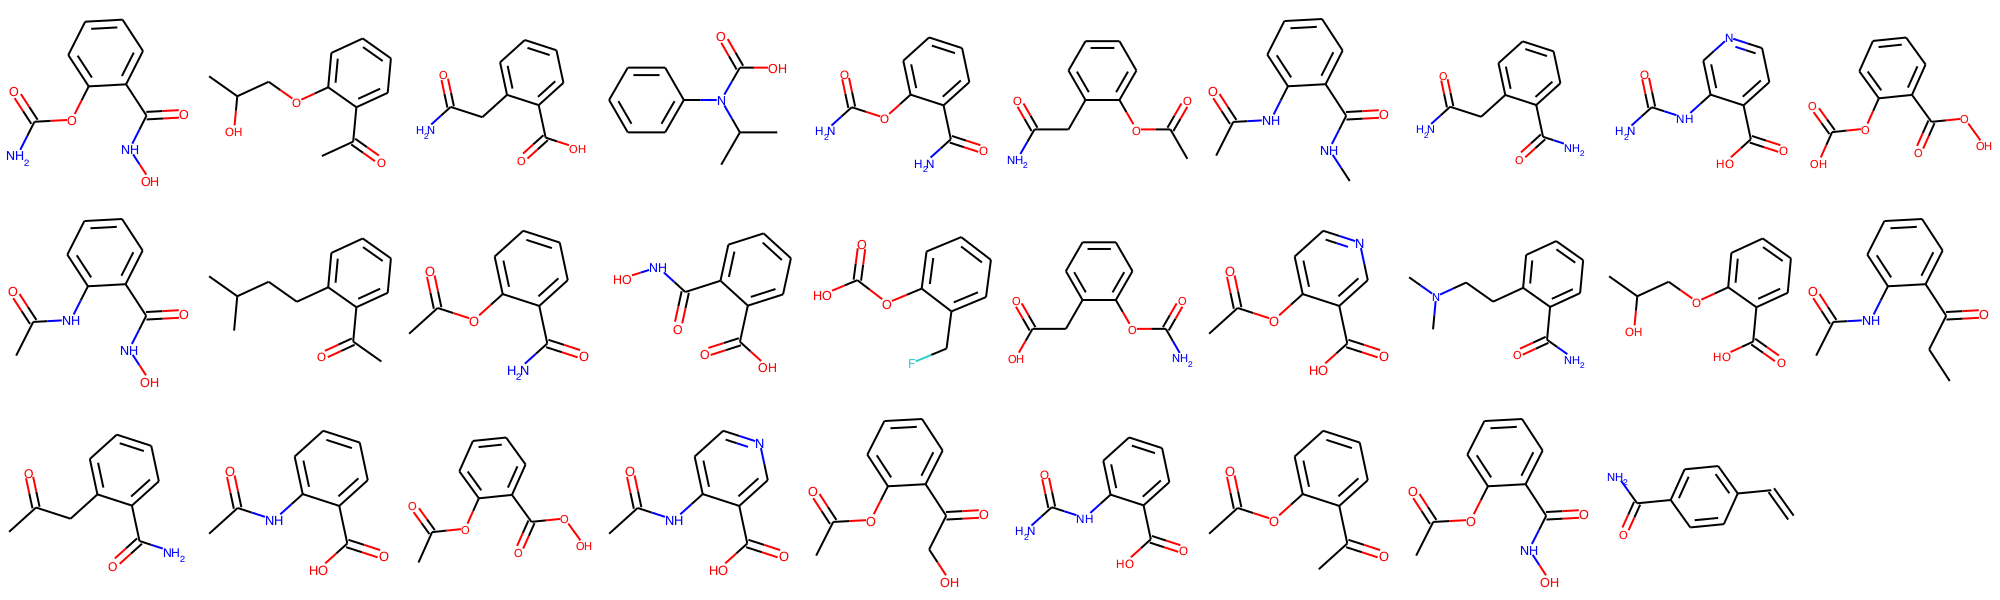

In [10]:
Draw.MolsToGridImage([mol[0] for mol in not_in_chembl], molsPerRow=10)

# Interpolation of two molecules
- Let's make a linear interpolation from aspirin to celecoxib latent representations and let's check what we got...
- Looks like is not a great idea to navigate from one molecule to another using linear space after all...

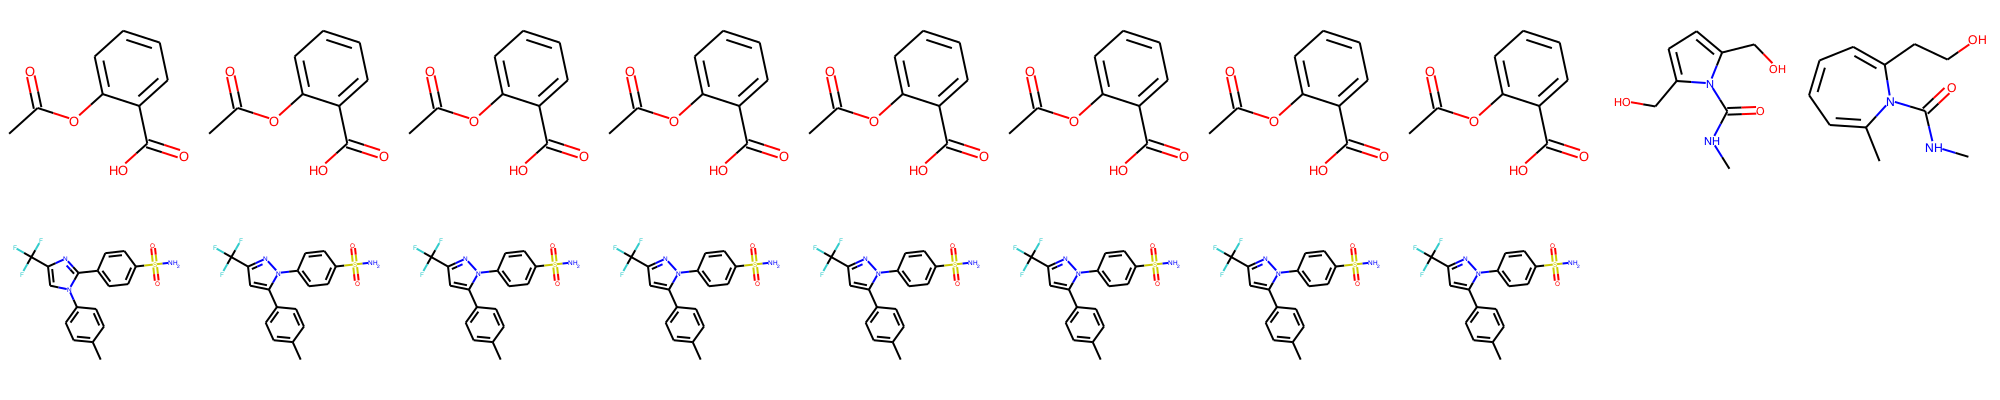

In [17]:
celecoxib_smiles = 'Cc1ccc(cc1)c2cc(nn2c3ccc(cc3)S(=O)(=O)N)C(F)(F)F'

steps = 100
results = interpolate(aspirin_smiles, celecoxib_smiles, steps, charset, model, latent_dim)

working_results = []
for smiles in results:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            working_results.append(mol)
    except:
        continue
                
Draw.MolsToGridImage(working_results, molsPerRow=10)